# Apparel Image Classification with WideResNet






In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00


## Introduction
This notebook implements a deep learning-based approach to classify images of clothing items from the Fashion MNIST dataset using the WideResNet architecture. The WideResNet model enhances ResNet by increasing its width, improving performance while maintaining computational efficiency.

The goal of this project is to accurately classify images into 10 categories, such as shirts, trousers, and dresses.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt
import torch
import torch.nn as nn
import numpy as np
import os
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

## Objective
To leverage the WideResNet architecture for:
- Improving image classification accuracy on the Fashion MNIST dataset.
- Demonstrating the effectiveness of wider residual networks.
- Exploring practical implementations of PyTorch and TensorFlow for data preprocessing and model building.


In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Dataset
The Fashion MNIST dataset contains:
- **Training Images**: 60,000 grayscale images (28x28 pixels each).
- **Test Images**: 10,000 grayscale images.

Each image belongs to one of 10 categories:
1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot


## Methodology
1. **Data Preprocessing**:
   - Normalized pixel values to [0, 1].
   - Reshaped input for compatibility with the WideResNet architecture.
2. **Model Architecture**:
   - Built a WideResNet with batch normalization, dropout, and global average pooling.
   - Configured for 10 output classes.
3. **Training**:
   - Implemented SGD optimizer with a learning rate of 0.01.
   - Used early stopping to prevent overfitting.
4. **Evaluation**:
   - Validated using accuracy and loss metrics.
   - Visualized validation accuracy over epochs.
5. **Prediction**:
   - Displayed predictions with sample test images.


In [ ]:
# Simulate command-line arguments using a dictionary
args_list = {
    'batch_size': 32,
    'epochs': 40,
    'base_lr': 0.01,
    'target_accuracy': 0.85,
    'patience': 2
}

In [ ]:
# Convert dictionary to an object for attribute-like access
class Args:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

args = Args(args_list)


In [ ]:
# Standard convolution block followed by batch normalization
class cbrblock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(cbrblock, self).__init__()
        self.cbr = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=(1, 1),
                               padding='same', bias=False),
                               nn.BatchNorm2d(output_channels),
                               nn.ReLU()
        )
    def forward(self, x):
        out = self.cbr(x)
        return out

In [ ]:
# Basic residual block
class conv_block(nn.Module):
    def __init__(self, input_channels, output_channels, scale_input):
        super(conv_block, self).__init__()
        self.scale_input = scale_input
        if self.scale_input:
            self.scale = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=(1, 1),
                               padding='same')
        self.layer1 = cbrblock(input_channels, output_channels)
        self.dropout = nn.Dropout(p=0.01)
        self.layer2 = cbrblock(output_channels, output_channels)

    def forward(self, x):
        residual = x
        out = self.layer1(x)
        out = self.dropout(out)
        out = self.layer2(out)
        if self.scale_input:
            residual = self.scale(residual)
        out = out + residual

        return out

In [ ]:
# Overall network
class WideResNet(nn.Module):
    def __init__(self, num_classes):
        super(WideResNet, self).__init__()
        nChannels = [1, 16, 160, 320, 640]

        self.input_block = cbrblock(nChannels[0], nChannels[1])

        # Module with alternating components employing input scaling
        self.block1 = conv_block(nChannels[1], nChannels[2], 1)
        self.block2 = conv_block(nChannels[2], nChannels[2], 0)
        self.pool1 = nn.MaxPool2d(2)
        self.block3 = conv_block(nChannels[2], nChannels[3], 1)
        self.block4 = conv_block(nChannels[3], nChannels[3], 0)
        self.pool2 = nn.MaxPool2d(2)
        self.block5 = conv_block(nChannels[3], nChannels[4], 1)
        self.block6 = conv_block(nChannels[4], nChannels[4], 0)

        # Global average pooling
        self.pool = nn.AvgPool2d(7)

        # Feature flattening followed by linear layer
        self.flat = nn.Flatten()
        self.fc = nn.Linear(nChannels[4], num_classes)

    def forward(self, x):
        out = self.input_block(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.pool1(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.pool2(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.pool(out)
        out = self.flat(out)
        out = self.fc(out)

        return out

def train(model, optimizer, train_loader, loss_fn, device):
    model.train()
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        labels = labels.to(device)
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Setting all parameter gradients to zero to avoid gradient accumulation
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Updating model parameters
        optimizer.step()

def test(model, test_loader, loss_fn, device):
    total_labels = 0
    correct_labels = 0
    loss_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            # Transfering images and labels to GPU if available
            labels = labels.to(device)
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Extracting predicted label, and computing validation loss and validation accuracy
            predictions = torch.max(outputs, 1)[1]
            total_labels += len(labels)
            correct_labels += (predictions == labels).sum()
            loss_total += loss

    v_accuracy = correct_labels / total_labels
    v_loss = loss_total / len(test_loader)

    return v_accuracy, v_loss

In [ ]:
if __name__ == '__main__':
    # Load the Fashion MNIST dataset using TensorFlow
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    # Normalize and preprocess the dataset
    train_images = train_images.reshape(-1, 1, 28, 28).astype('float32') / 255.0
    test_images = test_images.reshape(-1, 1, 28, 28).astype('float32') / 255.0

    # Convert to PyTorch tensors
    train_tensor = TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
    test_tensor = TensorDataset(torch.tensor(test_images), torch.tensor(test_labels))

    # Data loaders
    train_loader = DataLoader(train_tensor, batch_size=args.batch_size, shuffle=True) # Access using args.batch_size
    test_loader = DataLoader(test_tensor, batch_size=args.batch_size, shuffle=False)

    # Create the model and move to GPU device if available
    num_classes = 10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = WideResNet(num_classes).to(device)

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Define the SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=args.base_lr)

    val_accuracy = []
    total_time = 0  # Track total training time.

In [ ]:
    for epoch in range(args.epochs):
        t0 = time.time()

        train(model, optimizer, train_loader, loss_fn, device)

        epoch_time = time.time() - t0
        total_time += epoch_time  # Increment total time.

        # Compute images per second for each epoch.
        images_per_sec = len(train_loader) * args.batch_size / epoch_time

        # Test the model
        v_accuracy, v_loss = test(model, test_loader, loss_fn, device)
        val_accuracy.append(v_accuracy)

        # Print metrics
        print("Epoch = {:2d}: Epoch Time = {:5.3f}, Total Time = {:5.3f}, Images/sec = {:5.3f}, Validation Loss = {:5.3f}, Validation Accuracy = {:5.3f}".format(
            epoch + 1, epoch_time, total_time, images_per_sec, v_loss, val_accuracy[-1]))

        # Implement early stopping based on validation accuracy.
        if val_accuracy: # equivalent to if len(val_accuracy) > 0
            # Implement early stopping based on validation accuracy.
            if val_accuracy[-1] >= args.target_accuracy:
                if len(val_accuracy) >= args.patience and all(acc >= args.target_accuracy for acc in val_accuracy[-args.patience:]):
                    print('Early stopping after epoch {}'.format(epoch + 1))
                    break


In [ ]:
torch.save(model.state_dict(), 'fashion_mnist_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
test_accuracy, test_loss = test(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

Test Loss: 0.258, Test Accuracy: 0.905


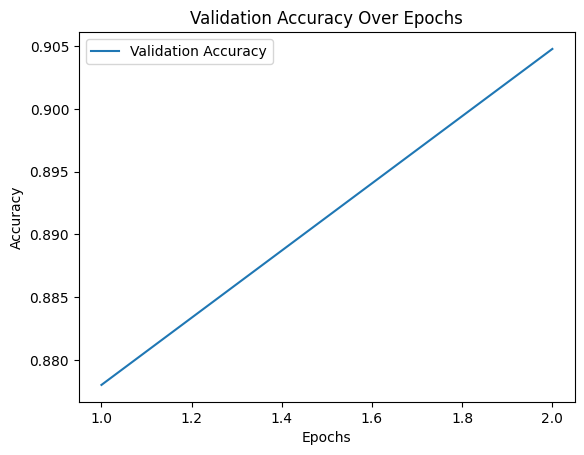

In [ ]:
import matplotlib.pyplot as plt

# Assuming `val_accuracy` is a list of tensors, convert each tensor to a CPU NumPy value
val_accuracy_cpu = [acc.cpu().numpy() for acc in val_accuracy]

# Generate the range of epochs
epochs = range(1, len(val_accuracy_cpu) + 1)

# Plot validation accuracy
plt.plot(epochs, val_accuracy_cpu, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Results
- **Validation Accuracy**: 90.5%
- **Test Loss**: 0.258
- **Test Accuracy**: 90.5%

The WideResNet model demonstrated robust performance, achieving high classification accuracy with minimal overfitting.


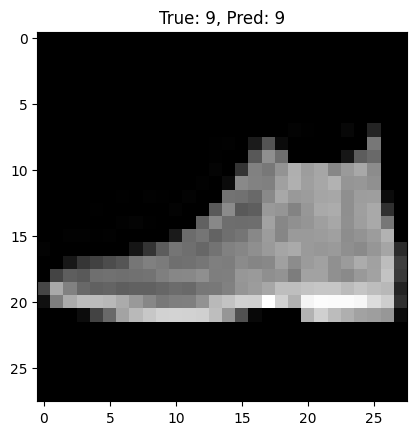

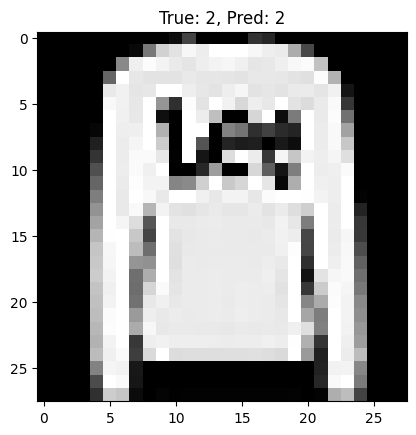

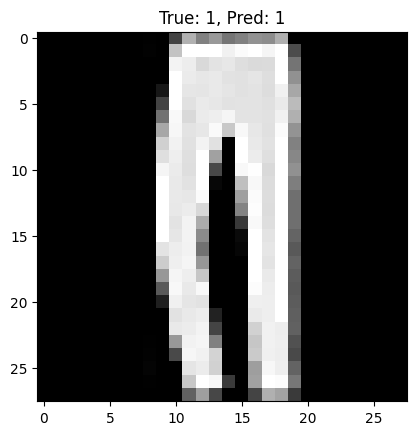

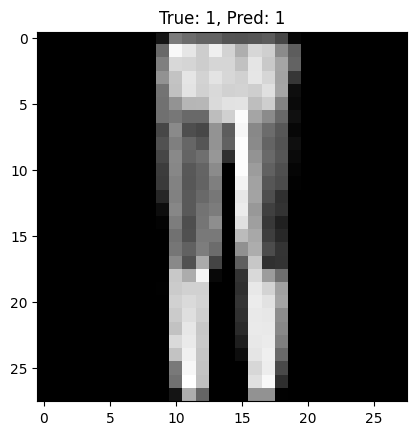

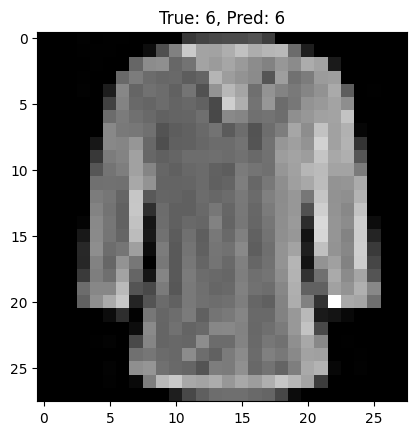

In [ ]:

# Get some test data
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Display the first 5 images and predictions
for i in range(5):
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    plt.title(f"True: {labels[i].item()}, Pred: {preds[i].item()}")
    plt.show()



## Conclusion
The WideResNet architecture proved to be effective for Fashion MNIST classification due to its ability to generalize well with increased width. This project showcases the potential of modern residual networks for image recognition tasks.


## References
1. WideResNet Paper: [https://arxiv.org/abs/1605.07146](https://arxiv.org/abs/1605.07146)

3. PyTorch Documentation: [https://pytorch.org/docs/](https://pytorch.org/docs/)
